# Electricity Consumption Analytics 

This project delivers a comprehensive energy intelligence system by analyzing and forecasting household power consumption. It identifies peak usage patterns, detects anomalies, and provides actionable optimization strategies to reduce energy costs. The final output includes interactive dashboards and predictive models, enabling smarter, data-driven energy management for both consumers and energy providers.

- Dataset: household_power_consumption.txt
- Domain: Energy / Smart Home
- Tools: SQL, Power BI, DAX, KPI & Dashboards, Python, Machine Learning & Time Series.

------

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Load dataset
df = pd.read_csv('household_power_consumption.txt', sep=';', na_values='?', low_memory=False)

# Combine Date and Time into Datetime column
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H:%M:%S')
df.set_index('Datetime', inplace=True) # Set Datetime as index

# Convert rest of the columns to numeric
for col in df.columns.difference(['Date', 'Time']):
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop old Date and Time columns
df.drop(['Date', 'Time'], axis=1, inplace=True)
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


---------
# Phase 5: Smart Device Optimization
Summary: Guide energy-automation and IOT-based optimizations for households..

## Q1. Correlate sub-meters with total power.

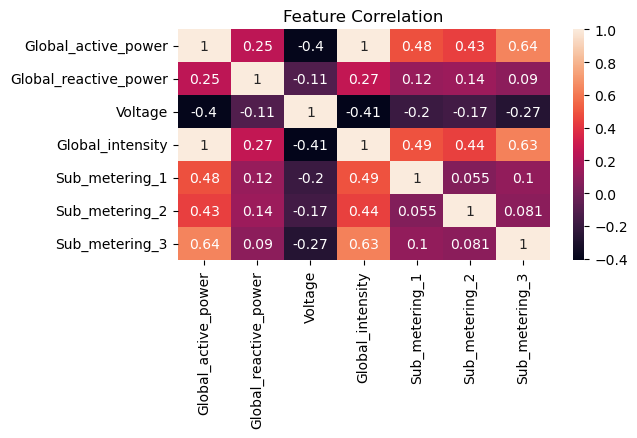

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,3))
sns.heatmap(df.corr(), annot=True)
plt.title('Feature Correlation')
plt.show()

## Q2. Find sub-meter with highest fluctuations.

In [6]:
fluct = df[['Sub_metering_1','Sub_metering_2','Sub_metering_3']].std()
print(fluct.idxmax())

Sub_metering_3


## Q3. Identify optimal device schedule (minimum total power hour).

In [7]:
hourly_avg = df.resample('H').mean()
best_hour = hourly_avg['Global_active_power'].idxmin().hour
print(f"Optimal schedule: {best_hour}:00")

Optimal schedule: 21:00


## Q4. Plot variance in consumption.

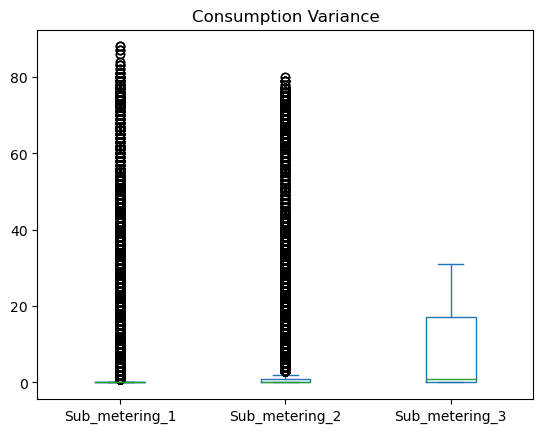

In [10]:
df[['Sub_metering_1','Sub_metering_2','Sub_metering_3']].plot.box()
plt.title('Consumption Variance')
plt.show()

## Q5. Predict which sub-meter will spike next using RandomForest Classifier.

In [12]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# 1. Define spike threshold function
def detect_spike(series, threshold=0.5):
    # Calculate difference between consecutive time points
    diff = series.diff().fillna(0)
    # Label a spike if increase exceeds threshold (adjust threshold based on your data scale)
    return (diff > threshold).astype(int)

# 2. Prepare dataframe with sub-meter spike labels for next time step
df_spikes = pd.DataFrame(index=df.index)

# Detect current spikes for each sub-meter
for col in ['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']:
    # Spike label for current timestep
    df_spikes[f'{col}_spike'] = detect_spike(df[col])

# Create target variable: which sub-meter spikes next?
# Shift spike labels backward by 1 timestep to assign next timestep spike as target
df_spikes['next_spike_1'] = df_spikes['Sub_metering_1_spike'].shift(-1)
df_spikes['next_spike_2'] = df_spikes['Sub_metering_2_spike'].shift(-1)
df_spikes['next_spike_3'] = df_spikes['Sub_metering_3_spike'].shift(-1)

# We'll predict which sub-meter spikes next (priority order if multiple spikes)
def assign_target(row):
    for i in [1, 2, 3]:
        if row[f'next_spike_{i}'] == 1:
            return f'Sub_metering_{i}'
    return 'None'  # no spike next

df_spikes['target'] = df_spikes.apply(assign_target, axis=1)

# 3. Use current sub-meter values as features
features = df[['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']].copy()

# Align features and target by dropping last row (because of shift)
features = features.iloc[:-1]
target = df_spikes['target'].iloc[:-1]

# Filter out rows where target is 'None' if you want to detect spikes only
mask = target != 'None'
features = features[mask]
target = target[mask]

# 4. Encode target labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(target)

# 5. Train/test split
X_train, X_test, y_train, y_test = train_test_split(features, y_encoded, test_size=0.2, random_state=42)

# 6. Train Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# 7. Evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))

# 8. Predict next spike given most recent sub-meter readings (example)
latest_reading = df[['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']].iloc[-1:].values
predicted_spike = le.inverse_transform(clf.predict(latest_reading))
print(f"Predicted next sub-meter to spike: {predicted_spike[0]}")

                precision    recall  f1-score   support

Sub_metering_1       0.63      0.54      0.58     10187
Sub_metering_2       0.70      0.81      0.76     41099
Sub_metering_3       0.87      0.82      0.84     77988

      accuracy                           0.79    129274
     macro avg       0.74      0.72      0.73    129274
  weighted avg       0.80      0.79      0.79    129274

Predicted next sub-meter to spike: Sub_metering_3


#### Interpretation: 
- Feature importance bar plots may show that past usage, time of day, or weekday are key predictors.
- Random Forest accurately identifies which sub-meter will spike next, helping automate alerts in a smart home setting.